In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [3]:
from problems import Burgers
problem = Burgers()

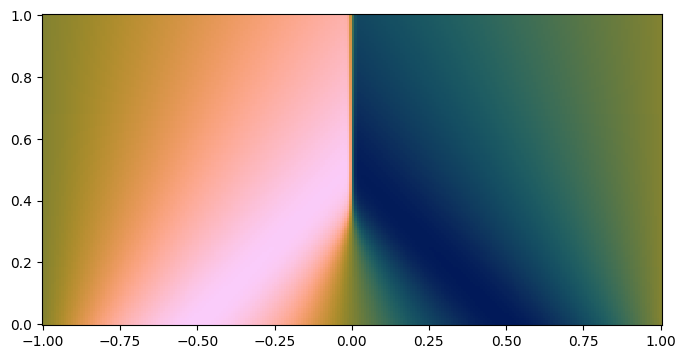

In [4]:
X, T, u_solution = problem.exact_solution(nx=256, nt=128)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax_exact = ax.pcolormesh(X, T, u_solution, cmap=cmap)

# Optimiser

In [81]:
class ExpLevenbergMarquardt:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        num_lambdas=50,
        init_lambda=1e0
    ):
        self.num_lambdas=50
        self.init_lambda=init_lambda

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {'lambda': self.init_lambda}

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array]
    ):
        last_lambda = state['lambda']
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def flat_residual_fn(p_flat):
            return residual_fn(unflatten(p_flat))

        residuals = residual_fn(params)
        current_loss = jnp.mean(residuals**2)

        J = jax.jacfwd(flat_residual_fn)(params_flat)
        U, S, Vt = jnp.linalg.svd(J, full_matrices=False)
        Rhs = U.T @ residuals
        
        lambdas = jnp.logspace(jnp.log10(last_lambda) / 10, jnp.log10(last_lambda * 10), self.num_lambdas)

        sv_cutoffs = jnp.array([0.0,])

        # Create a meshgrid and flatten it to get all (lambda, sv_cutoff) pairs
        lambdas_grid, sv_cutoffs_grid = jnp.meshgrid(lambdas, sv_cutoffs)
        candidates = jnp.stack([lambdas_grid.ravel(), sv_cutoffs_grid.ravel()], axis=1)

        # --- Parallel evaluation of the grid ---
        def evaluate_candidate(candidate: jax.Array) -> tuple[jnp.array, jax.Array]:
            """
            Evaluates a single (lambda, sv_cutoff) candidate pair.
            """
            trial_lambda, sv_cutoff = candidate[0], candidate[1]

            S_inv = S / (S**2 + trial_lambda)

            # S_inv_final = jnp.where(S < sv_cutoff, 0.0, S_inv)
            
            delta = -Vt.T @ (S_inv * Rhs)

            trial_params = unflatten(params_flat + delta)
            trial_loss = jnp.mean(residual_fn(trial_params)**2)
            return trial_loss, delta

        # Vmap over all candidates to find all trial losses and corresponding deltas
        all_trial_losses, all_deltas = jax.vmap(evaluate_candidate)(candidates)

        # --- Find the best candidate from the grid search ---
        best_idx = jnp.argmin(all_trial_losses)
        best_delta = all_deltas[best_idx]
        best_lambda = candidates[best_idx, 0]
        best_sv_cutoff = candidates[best_idx, 1]

        updates = unflatten(best_delta)
        new_state = {'lambda': best_lambda}

        metrics = {
            'loss': current_loss,
            'lambda': best_lambda,
            'selected_sv_cutoff': best_sv_cutoff,
            'singular_values': S,
            'search_direction_norm': jnp.linalg.norm(best_delta),
            'used_svs': jnp.sum(S > best_sv_cutoff)
        }

        return current_loss, updates, new_state, metrics



@partial(jax.jit, static_argnums=(3, 4, 6))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points, nu):
    def residual_fn_for_optimizer(p):
        rebuilt_model = eqx.combine(p, static_parts)
        return problem.physics_residual(problem.residual_fn, rebuilt_model, collocation_points, nu)

    loss, updates, new_opt_state, metrics = optimiser.update(params, opt_state, residual_fn_for_optimizer)
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics

<function matplotlib.pyplot.show(close=None, block=None)>

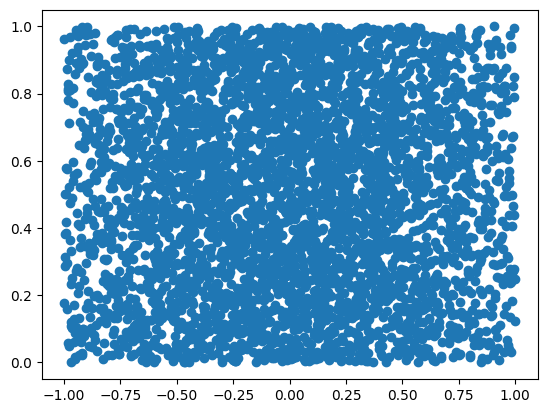

In [86]:
key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_collocation_points = 2**12
layer_sizes = [2, 16, 16, 16, 16, 16, 1]
# -----------------------

model_key, data_key = jax.random.split(key)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
collocation_points = problem.get_collocation_points(n_collocation_points, seed=1, concentration_factor=3.0)

nu = problem.nu

plt.scatter(collocation_points[:, 0], collocation_points[:, 1])
plt.show

In [88]:
optimiser = ExpLevenbergMarquardt(
    num_lambdas=50
)
opt_state = optimiser.init(params)
history = History()

start_time = time.monotonic()

print(f"Starting PINN training with {type(optimiser).__name__}...")
for epoch in range(500):
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, optimiser, problem, collocation_points, nu
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")


model = eqx.combine(params, static)
print("Training complete.")


Starting PINN training with ExpLevenbergMarquardt...
Epoch 20, Loss: 1.049e-03, Time elapsed: 22.12 s
Epoch 40, Loss: 3.596e-04, Time elapsed: 33.99 s
Epoch 60, Loss: 1.405e-04, Time elapsed: 45.81 s
Epoch 80, Loss: 4.691e-05, Time elapsed: 57.07 s
Epoch 100, Loss: 2.311e-05, Time elapsed: 68.87 s
Epoch 120, Loss: 1.106e-05, Time elapsed: 80.35 s
Epoch 140, Loss: 7.029e-06, Time elapsed: 91.70 s
Epoch 160, Loss: 5.094e-06, Time elapsed: 102.77 s
Epoch 180, Loss: 4.075e-06, Time elapsed: 113.72 s
Epoch 200, Loss: 3.434e-06, Time elapsed: 125.16 s
Epoch 220, Loss: 2.990e-06, Time elapsed: 136.77 s
Epoch 240, Loss: 2.657e-06, Time elapsed: 148.06 s
Epoch 260, Loss: 2.403e-06, Time elapsed: 159.20 s
Epoch 280, Loss: 2.205e-06, Time elapsed: 170.09 s
Epoch 300, Loss: 2.049e-06, Time elapsed: 181.23 s
Epoch 320, Loss: 1.916e-06, Time elapsed: 192.83 s
Epoch 340, Loss: 1.805e-06, Time elapsed: 204.08 s
Epoch 360, Loss: 1.712e-06, Time elapsed: 214.68 s
Epoch 380, Loss: 1.631e-06, Time elapsed

Relative L2 Error: 2.106e-03


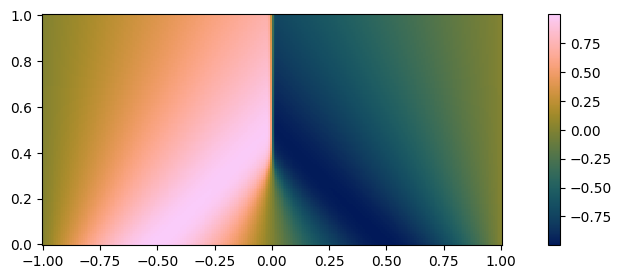

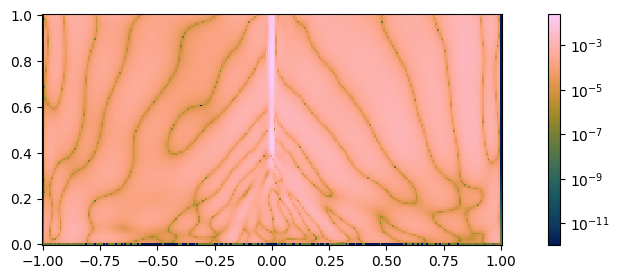

In [84]:
u_pred = model.predict(X, T)

error = jnp.abs(u_solution - u_pred)
rel_l2_error = jnp.linalg.norm(error) / jnp.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_solution = ax.pcolormesh(X, T, u_pred, cmap=cmap)
fig.colorbar(nn_solution, ax=ax, pad=0.05)
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-12, vmax=error.max())
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-12, norm=norm, cmap=cmap)
fig.colorbar(nn_error, ax=ax, pad=0.05)
plt.show()

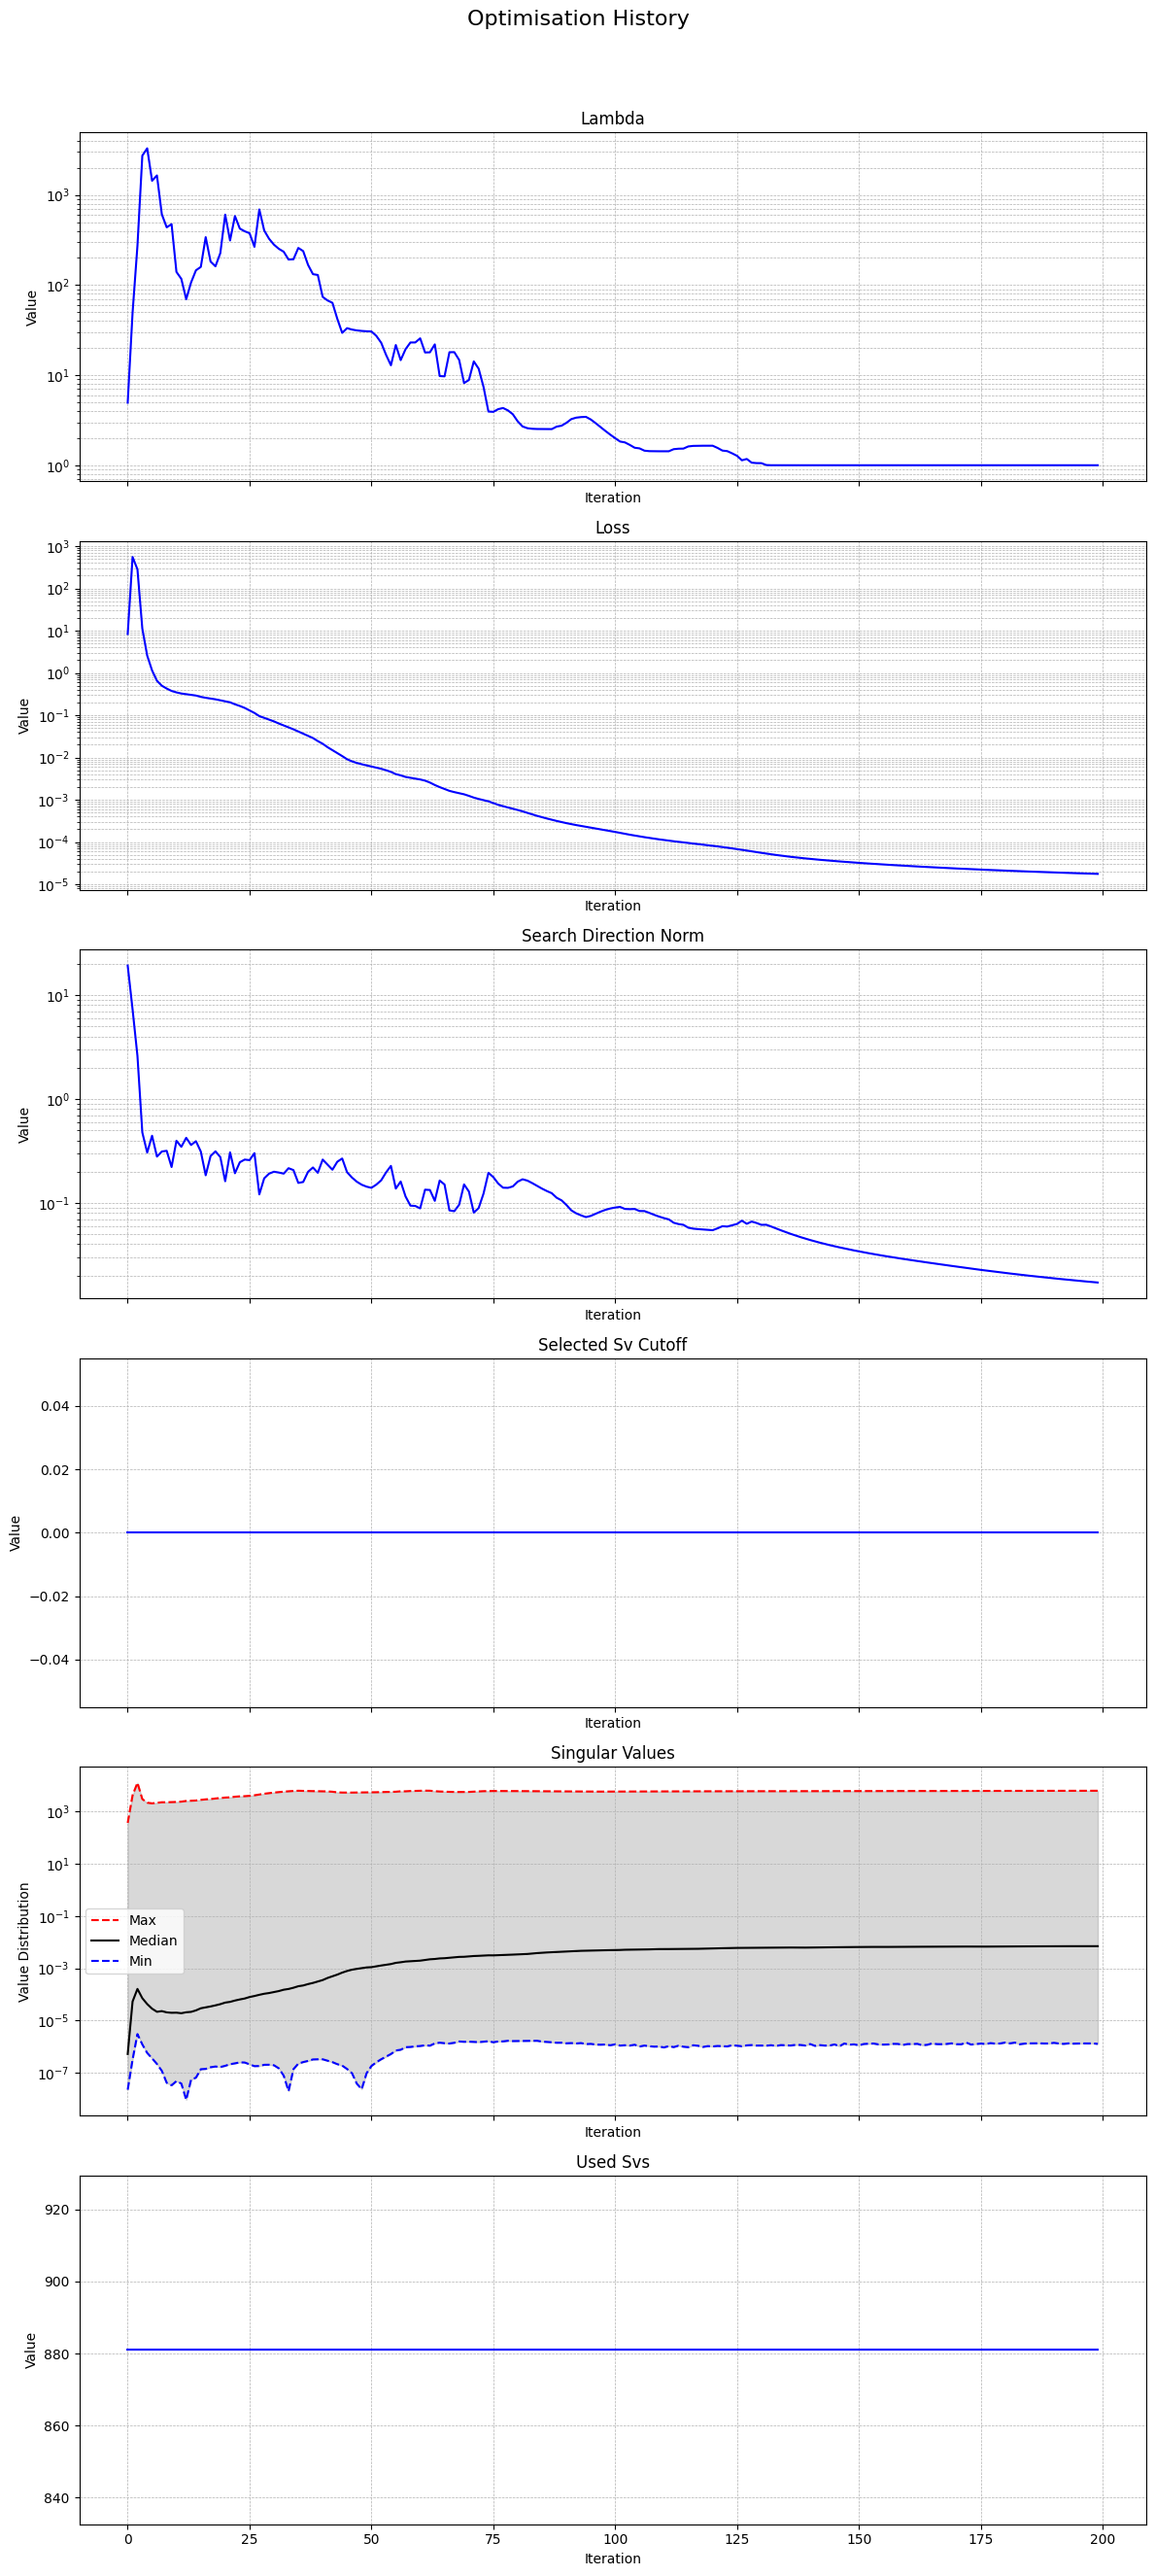

In [85]:
history.plot()